<a href="https://colab.research.google.com/github/code-il/CONSTELLATION-DETECTION/blob/main/CONSTELLATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Constellation detection by comparing descriptors**



In [ ]:
import cv2
import numpy as np
import os #for joining the directories
import matplotlib.pyplot as plt

import imutils #for rotating

from google.colab import drive
drive.mount('/content/drive') #mount google drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
impath='/content/drive/My Drive/constellation' #constellation

files = os.listdir(impath)

# Filter out only image files
image_files = [file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'gif'))]

# Print the filenames of the image files
for image_file in image_files:
    print(image_file)

# If you want to display the images, you can do it like this:
for image_file in image_files:
    # Open the image using PIL
    image_path = os.path.join(impath, image_file)
    image = Image.open(image_path)
    # Display the image
    plt.imshow(image)

# **SAVE DESCRIPTORS**



**1. Function `save_descriptors`:**

- **Loads the image:**
    - Takes `image_path` as input.
    - Uses OpenCV's `cv2.imread` to read the image from the path.
- **Converts to grayscale:**
    - Converts the image to grayscale using `cv2.COLOR_BGR2GRAY`.
- **Computes SIFT descriptors:**
    - Creates a SIFT object using `cv2.SIFT_create()`.
    - Detects keypoints and computes SIFT descriptors using `detectAndCompute`.
- **Saves descriptors:**
    - Takes `descriptor_path` as input.
    - Uses NumPy's `np.save` to save the descriptors to a file in NumPy's `.npy` format.

**2. Main program:**

- **Sets directories:**
    - Specifies the `image_dir` containing input images.
    - Specifies the `descriptor_dir` to store computed descriptors.
- **Creates output directory:**
    - Uses `os.makedirs` to create the `descriptor_dir` if it doesn't exist.
- **Loops through images:**
    - Iterates through each filename in `image_dir` using a `for` loop.
    - Checks if the filename has a `.jpg` or `.png` extension.
    - Constructs full image path and descriptor path.
    - Calls `save_descriptors` to process the image and save descriptors.
    - Prints a confirmation message.


In [ ]:

# Function to compute and save descriptors
def save_descriptors(image_path, descriptor_path):
  image = cv2.imread(image_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  sift = cv2.SIFT_create()
  keypoints, descriptors = sift.detectAndCompute(gray, None)
  np.save(descriptor_path, descriptors)

# Define your image directory and output directory for descriptors
image_dir = "/content/drive/My Drive/constellationinput"
descriptor_dir = "/content/drive/My Drive/constellation"

# Create the output directory if it doesn't exist
os.makedirs(descriptor_dir, exist_ok=True)  # Create directory if needed

# Loop through images in your directory
for filename in os.listdir(image_dir):
  if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image formats
    image_path = os.path.join(image_dir, filename)
    descriptor_path = os.path.join(descriptor_dir, filename[:-4] + ".npy")  # Remove extension and add .npy
    save_descriptors(image_path, descriptor_path)
    print(f"Descriptors saved for: {filename}")



Descriptors saved for: bigdipper.jpg
Descriptors saved for: cassiopeia.png
Descriptors saved for: hercules.png
Descriptors saved for: lyra.png


In [ ]:

import numpy as np

descriptor_path = "/content/drive/My Drive/constellation/bigdipper.npy"  # Replace with the actual path to your descriptor file
descriptors = np.load(descriptor_path, allow_pickle=True)

print(descriptors)


[[41. 34.  5. ...  4.  0.  0.]
 [ 0.  0.  0. ...  6. 19. 29.]
 [29.  0.  0. ...  0.  0.  0.]
 ...
 [13.  3.  0. ...  6. 11.  8.]
 [ 0.  0.  0. ...  1.  1.  1.]
 [27. 44. 24. ...  2.  1.  1.]]


# **DETECTION**

USING BRUTE FORCE

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt  # for optional visualization

# Function to load descriptors from a NPY file
def load_descriptors(descriptor_path):
    descriptors = np.load(descriptor_path)
    return descriptors

# Function to match descriptors and classify image
def match_and_classify(test_descriptors, reference_descriptors_dir):
    best_match_filename = None
    best_match_score = 0

    for filename in os.listdir(reference_descriptors_dir):
        if filename.endswith(".npy"):
            reference_descriptors_path = os.path.join(reference_descriptors_dir, filename)
            reference_descriptors = load_descriptors(reference_descriptors_path)

            # Use brute-force matcher for now (explore FLANN or other techniques for efficiency)
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(test_descriptors, reference_descriptors, k=2)

            # Apply Lowe's ratio test for robust matching
            # It keeps only matches (good_matches) where the distance to the closest match (m.distance) is less than 0.75 times the distance to the second closest match (n.distance).
            good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

            match_score = len(good_matches)
            if match_score > best_match_score:
                best_match_filename = filename[:-4]  # Remove .npy extension
                best_match_score = match_score
                print(best_match_score)

    if best_match_score > 0:  # Consider a threshold for reliable classification
        return best_match_filename
    else:
        return "No match found"


USING FLANN

In [ ]:
!pip install opencv-contrib-python

In [ ]:
import cv2
import numpy as np
import os


# Function to load descriptors from a NPY file (unchanged)
def load_descriptors1(descriptor_path):
    descriptors = np.load(descriptor_path)
    return descriptors

# Function to match descriptors and classify image using FLANN
def match_and_classify_flann(test_descriptors, reference_descriptors_dir,notrees):
    best_match_filename = None
    best_match_score = 0
    trees=notrees
    # Create FLANN matcher
    index_params = dict(algorithm= 1, trees=7) #FLANN_INDEX_KDTREE,set the number of trees to be used in the k-means indexing process.
    search_params = dict(checks=50)  # number of candidate neighbors to consider during the search.
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    for filename in os.listdir(reference_descriptors_dir):
        if filename.endswith(".npy"):
            reference_descriptors_path = os.path.join(reference_descriptors_dir, filename)
            reference_descriptors = load_descriptors1(reference_descriptors_path)

            # Match descriptors with FLANN
            matches = flann.knnMatch(test_descriptors, reference_descriptors, k=2)
            good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]  # Lowe's ratio test

            match_score = len(good_matches)
            if match_score > best_match_score:
                best_match_filename = filename[:-4]  # Remove .npy extension
                best_match_score = match_score
                print(best_match_score)
                print(best_match_filename)

    if best_match_score > 0:  # Consider a threshold for reliable classification
        return best_match_filename
    else:
        return "No match found"


 TEST IMAGES 
 1.BIG DIPPER  
 2.CASSIOPEIA 
 3.HERCULES 
 5. EXIT
SELECT TEST IMAGE:1
select number of trees:
ENTER NUMBER OF TREES FOR FLANN:3
24
25
bigdipper
Classification result: bigdipper
Classification result for flann: bigdipper


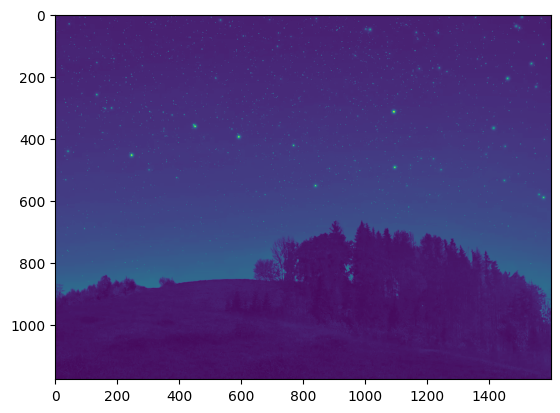

In [ ]:
test_image_path = ""
print("\n TEST IMAGES \n 1.BIG DIPPER  \n 2.CASSIOPEIA \n 3.HERCULES \n 5. EXIT")
choice=int(input("SELECT TEST IMAGE:"))
if(choice==1):
  test_image_path = "/content/bigdipper2.jpg"
elif(choice==2):
  test_image_path = "/content/cass2.jpg"
elif(choice==3):
  test_image_path = "/content/hercules2.jpg"
elif(choice==4):
  test_image_path = "/content/lyra2.jpg"

print("select number of trees:")
trees=int(input("ENTER NUMBER OF TREES FOR FLANN:"))
test_image = cv2.imread(test_image_path)
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
#imgrotate=imutils.rotate(gray,15)

sift = cv2.SIFT_create()

keypoints, descriptors = sift.detectAndCompute(gray, None)

cv2.drawKeypoints(test_image,keypoints,gray)
plt.imshow(gray)

# Save test descriptors to a NPY file (optional for later analysis)
test_descriptors_path = "/content/drive/My Drive/constellationtest"
np.save(test_descriptors_path, descriptors)

# Match and classify
reference_descriptors_dir = "/content/drive/My Drive/constellation"  # Path to your directory
classification_result = match_and_classify(descriptors, reference_descriptors_dir)
classification_flann = match_and_classify_flann(descriptors, reference_descriptors_dir,trees)
print("Classification result:", classification_result)
print("Classification result for flann:", classification_flann)

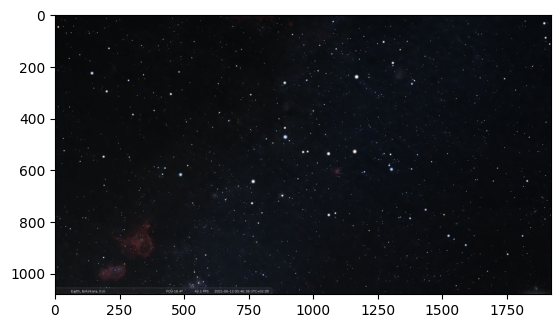

In [ ]:
for filename in os.listdir(image_dir):
  if filename == classification_result+".jpg" or filename == classification_result+".png" :  # Check for image formats
    image_path = os.path.join(image_dir, filename)
image1 = Image.open(image_path)
plt.imshow(image1)

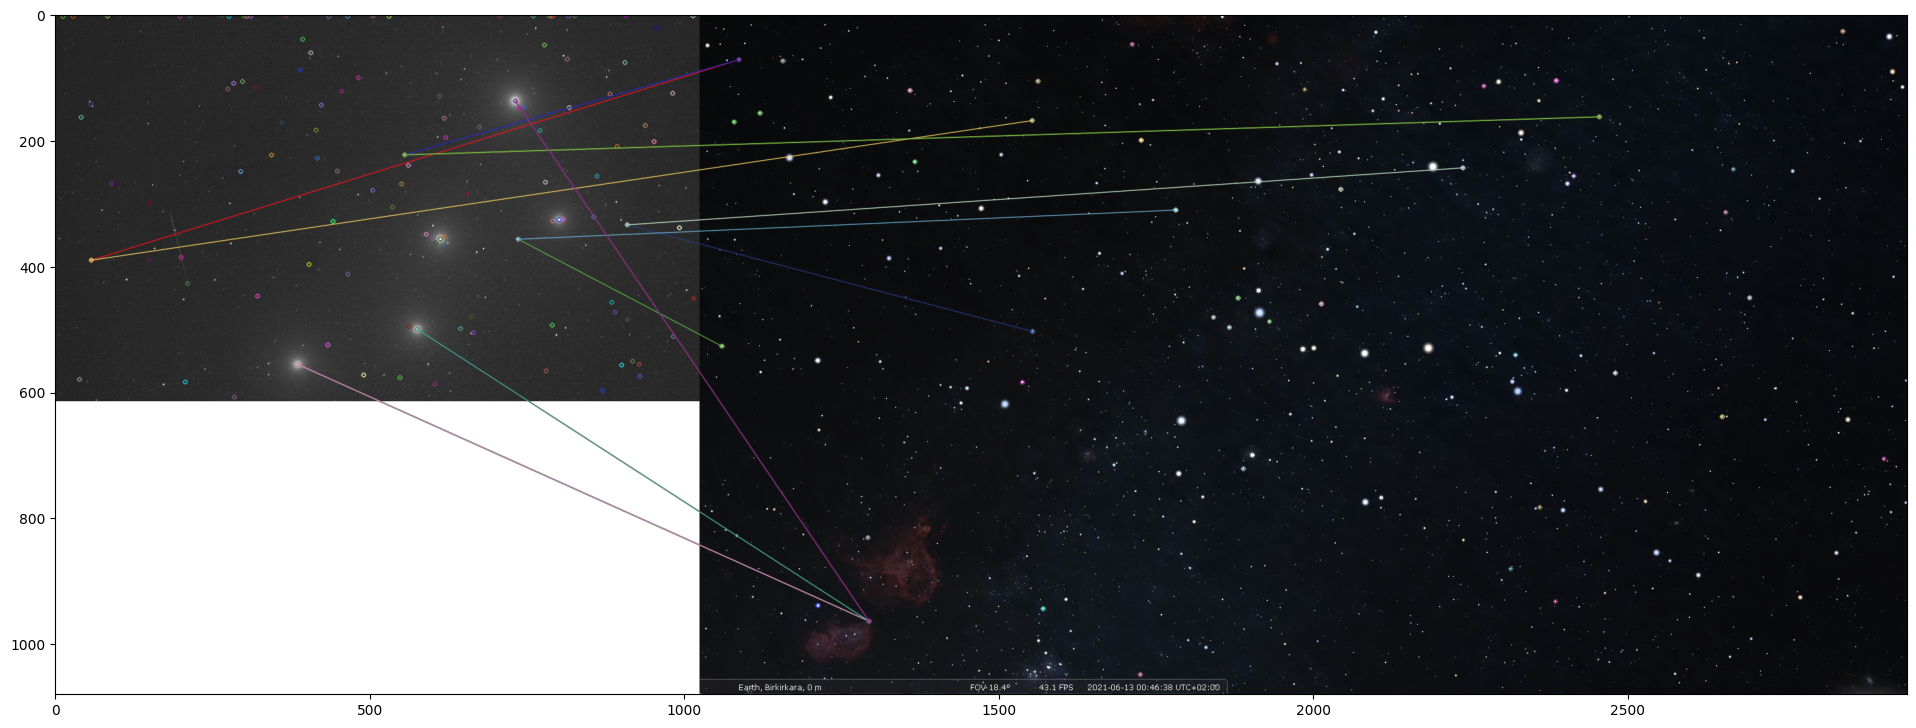

In [ ]:
# prompt: for the images in previous blocks : gray and image1, do sift and bruteforce match them

import matplotlib.pyplot as plt
# Extract SIFT features from both images
sift = cv2.SIFT_create(nfeatures=200,contrastThreshold=0.01)
kp1, des1 = sift.detectAndCompute(gray, None)

import numpy as np
# Convert image1 to a NumPy array
image1 = np.array(image1)
kp2, des2 = sift.detectAndCompute(image1, None)

# Match features using brute force matcher
bf = cv2.BFMatcher()
matches = bf.match(des1, des2)
matches=sorted(matches,key=lambda val:val.distance)

out1_2=cv2.drawMatches(gray,kp1,image1,kp2,matches[:20],None)

plt.figure(figsize=(30,30))
plt.subplot(3,1,1)
#plt.title("MATCHING KEYPOINT")
plt.imshow(out1_2)

